In [223]:
from tools import analysistools as atools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random
from scipy.stats import sem
from mpl_toolkits.mplot3d import Axes3D

In [2]:
xyzapath = '/Users/joelforster/Projects/optidb/clus/rebuilds'

In [3]:
xyzas = [os.path.join(xyzapath,f) for f in filter(lambda x: '.xyza' in x, os.listdir(xyzapath))]

In [4]:
nxyzas = filter(lambda c: '-1' in c, xyzas)
bxyzas = filter(lambda c: '-1' not in c, xyzas)

In [33]:
# contacts = [atools.measureLigandContact(f) for f in random.sample(xyzas,10)]

In [34]:
nonBudContacts = [atools.measureLigandContact(f) for f in nxyzas]
budContacts = [atools.measureLigandContact(f) for f in bxyzas]

In [114]:
mbcontact = {}
mbcontactlist = []
mberr = []

nbcontact = {}
nbcontactlist = []
nberr = []

for x in budContacts[0][0]:
    mbcontact[x[0]] = []
    mbcontactlist.append([x[0],[]])
for f in budContacts:
    for g in f[0]:
        mbcontact[g[0]].append(g[1])
for v in mbcontactlist:
    v[1] = np.mean(mbcontact[v[0]])
    mberr.append([v[0],np.std(mbcontact[v[0]])])
    
for x in nonBudContacts[0][0]:
    nbcontact[x[0]] = []
    nbcontactlist.append([x[0],[]])
for f in nonBudContacts:
    for g in f[0]:
        nbcontact[g[0]].append(g[1])
for v in nbcontactlist:
    v[1] = np.mean(nbcontact[v[0]])
    nberr.append([v[0],np.std(nbcontact[v[0]])])
    
mbcontact = {}
nbcontact = {}

<Container object of 3 artists>

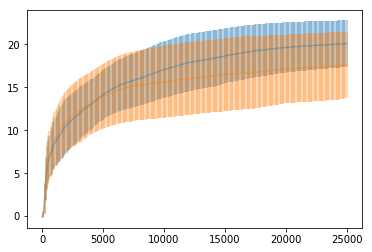

In [119]:
plt.errorbar([p[0] for p in mbcontactlist],[p[1] for p in mbcontactlist],yerr=[p[1] for p in mberr],alpha=0.4)
plt.errorbar([p[0] for p in nbcontactlist],[p[1] for p in nbcontactlist],yerr=[p[1] for p in nberr],alpha=0.4)
# for contact in nonBudContacts:
#     plt.plot([i[0] for i in contact[0]],[i[1] for i in contact[0]],color='blue')

In [36]:
njitters = [atools.jitterLigandContact(c[0],3,'full') for c in nonBudContacts]
bjitters = [atools.jitterLigandContact(c[0],3,'full') for c in budContacts]

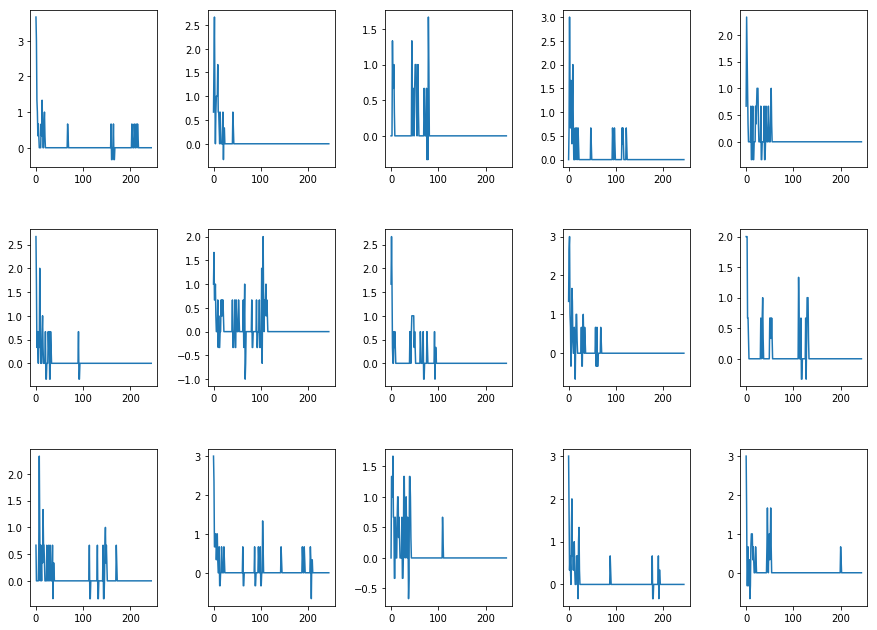

In [37]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(1,16):
    ax = plt.subplot(4, 5, i)
    ax.plot(bjitters[i][1])


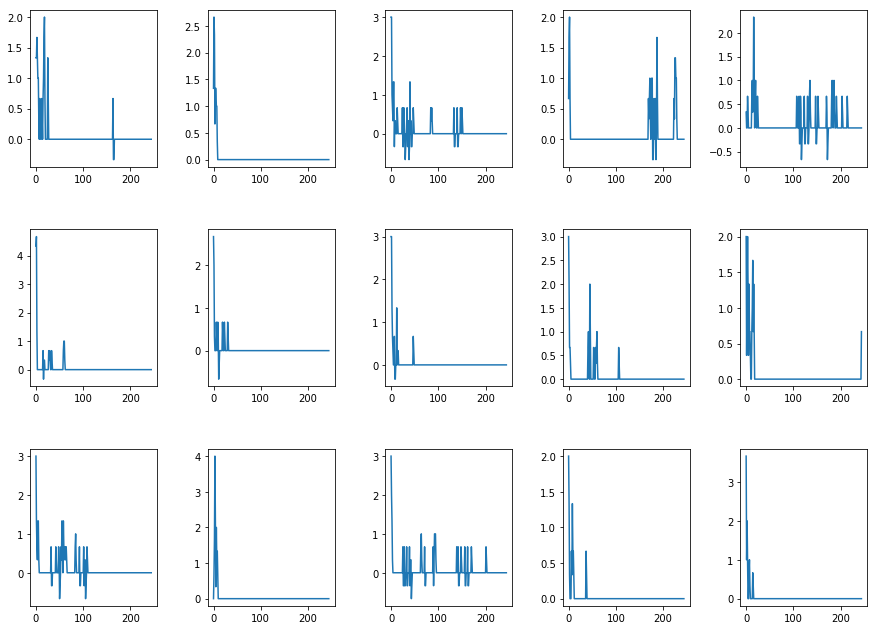

In [38]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(1,16):
    ax = plt.subplot(4, 5, i)
    ax.plot(njitters[i][1])

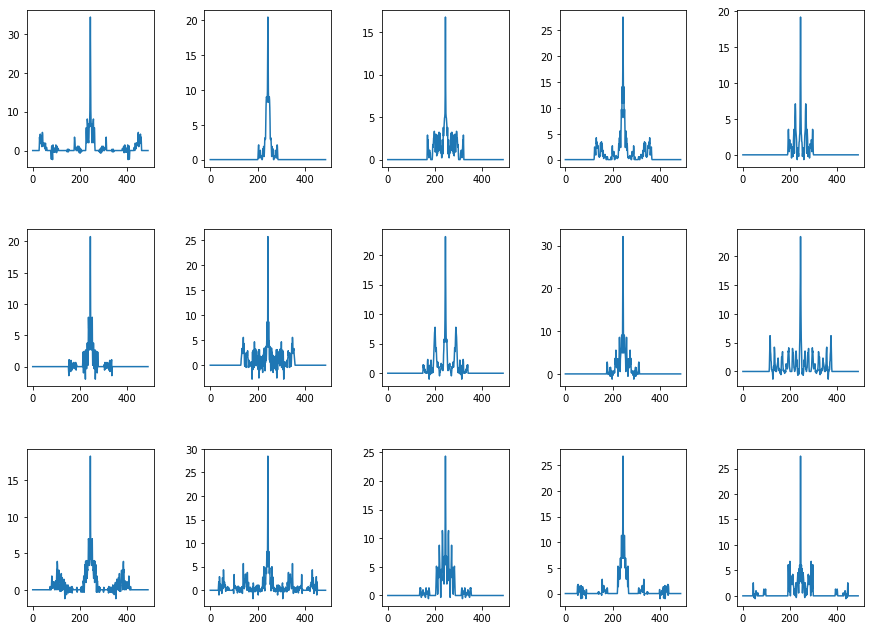

In [39]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(1,16):
    ax = plt.subplot(4, 5, i)
    corr = np.correlate(bjitters[i][1],bjitters[i][1],mode='full')
    ax.plot(corr)

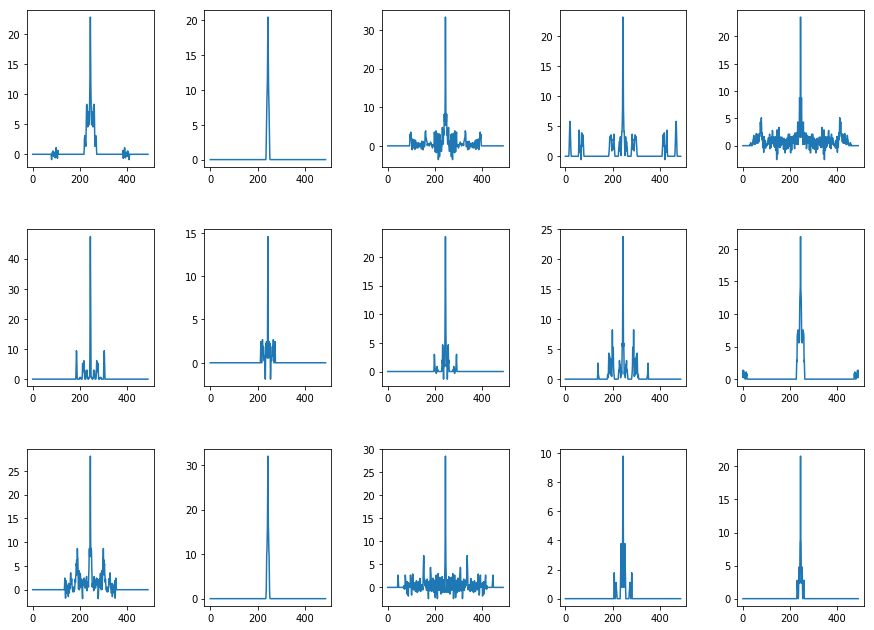

In [40]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(1,16):
    ax = plt.subplot(4, 5, i)
    corr = np.correlate(njitters[i][1],njitters[i][1],mode='full')
    ax.plot(corr)

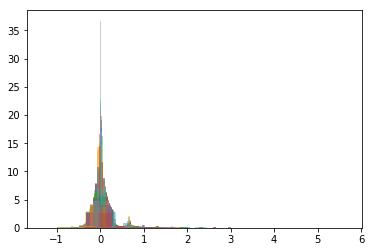

In [41]:
nmeans = []
nsds = []
for c in njitters:
    sns.distplot(c[1][:],kde=False,norm_hist=True)
    nmeans.append(np.mean(c[1]))
    nsds.append(np.std(c[1]))

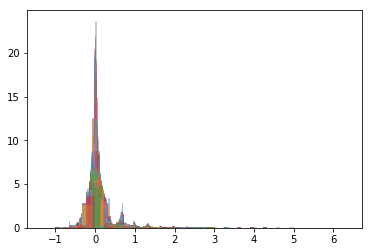

In [42]:
bmeans = []
bsds = []
for c in bjitters:
    sns.distplot(c[1][:],kde=False,norm_hist=True)
    bmeans.append(np.mean(c[1]))
    bsds.append(np.std(c[1]))

In [43]:
print(np.mean(bmeans),np.mean(nmeans))

(0.07614420326434487, 0.06566392790882612)


In [44]:
print(np.mean(bsds),np.mean(nsds))

(0.3197581120958373, 0.3064779971839226)


ValueError: invalid literal for int() with base 10: 'ITEM: TIMESTEP\n'

In [94]:
def readXYZA(filepath,headerSize=8):
    data = {}
    with open(filepath, "r") as f:
        lines = f.readlines()
        ts = 0
        steps = []
        hPos = 0
        currentStep = {}
        for i in range(len(lines)):
            if str('ITEM: TIMESTEP') in lines[i]:
                if 't' in currentStep:
                    steps.append(currentStep)   
                hPos = i
                ts = int(lines[i+1])
                currentStep = {'t':ts,'data':[]}
            elif str('ITEM: NUMBER OF ATOMS') in lines[i]:
                data['natoms'] = int(lines[i+1])  
            elif str('ITEM: BOX BOUNDS') in lines[i]:
                currentStep['xsize'] = [float(b) for b in lines[i+1].split(' ')]
                currentStep['ysize'] = [float(b) for b in lines[i+2].split(' ')]
                currentStep['zsize'] = [float(b) for b in lines[i+3].split(' ')]
            elif str('ITEM: ATOMS') in lines[i]:
                data['columns'] = lines[i].replace('\n','').split(' ')[2:]
            if(i-hPos>headerSize):
                atomStep = {}
                atomData = lines[i].replace('\n','').split(' ')
                for j,c in enumerate(data['columns']):
                    atomStep[c] = float(atomData[j]) if '.' in atomData[j] else int(atomData[j])
                currentStep['data'].append(atomStep)
        data['steps'] = steps
    return data
            

In [239]:
def getRotationData(simData):
    coreId = -1
    refId = -1
    for i,a in enumerate(simData['steps'][0]['data']):
        if a['type'] == 2:
            coreId = i
        if a['type'] == 3:
            refId = i

    r = []
    rotation = []
    
    for i,s in enumerate(simData['steps']):
        core = s['data'][coreId]
        ref = s['data'][refId]
        vCore = [core['x'],core['y'],core['z']]
        vRef = [ref['x'],ref['y'],ref['z']]
        r.append(np.subtract(vRef,vCore))
        if i>0:
            rotation.append(np.subtract(r[-1],r[0]))
            
    return rotation

In [240]:
def plotRotationTrajectory(data):
    colors = []
    colStep = 1.0/float(len(data))
    for i in range(len(data)):
        colors.append((colStep*i,0.0,1.0-colStep*i,1.0))
        
    startPoint = 0
    X, Y, Z = zip(*data[startPoint:])
    fig = plt.figure(figsize=(13, 9))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(X,Y,Z,alpha=0.4)
    ax.scatter(X, Y, Z,c=colors[startPoint:])
    return fig

In [241]:
d = readXYZA(nxyzas[1])

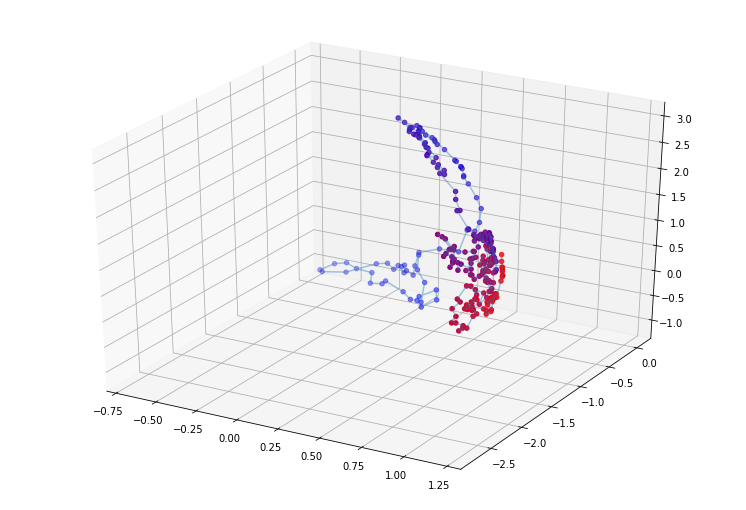

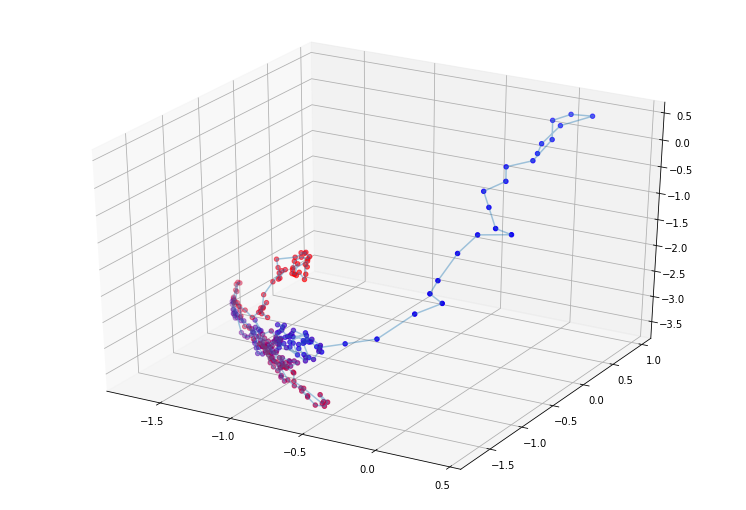

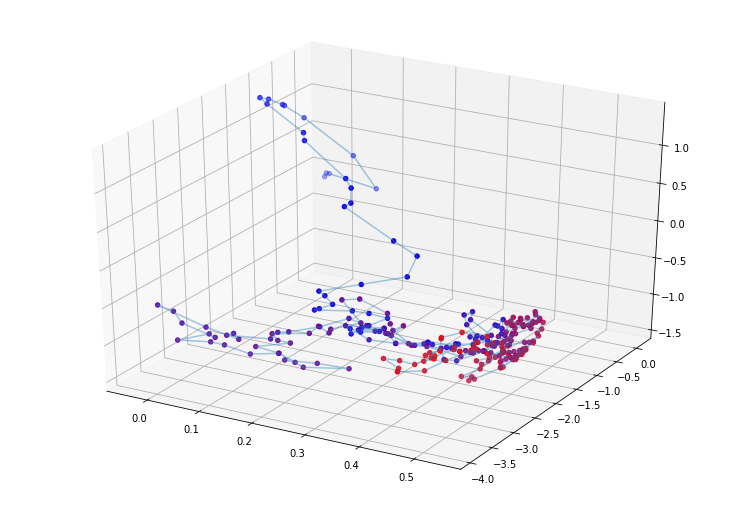

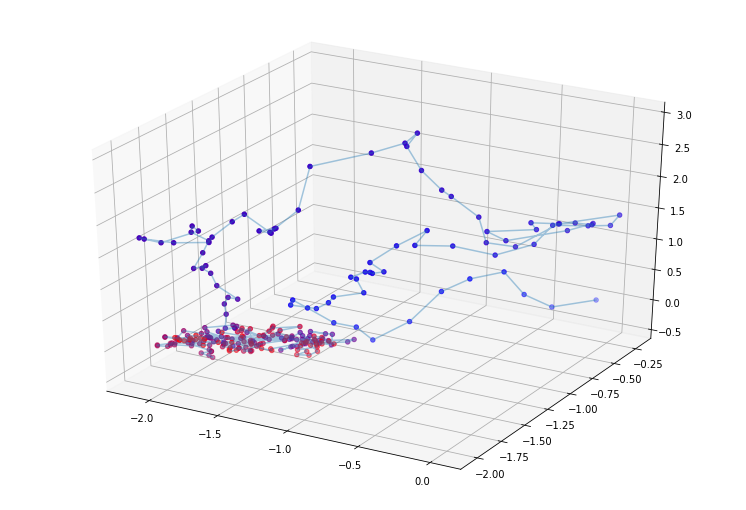

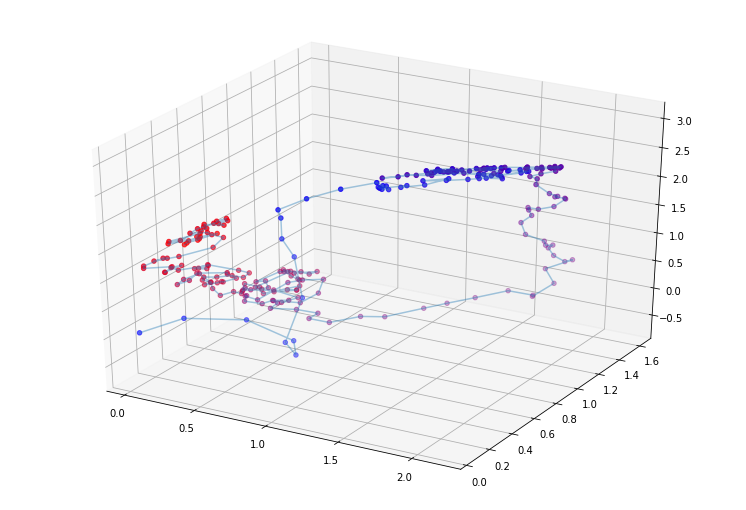

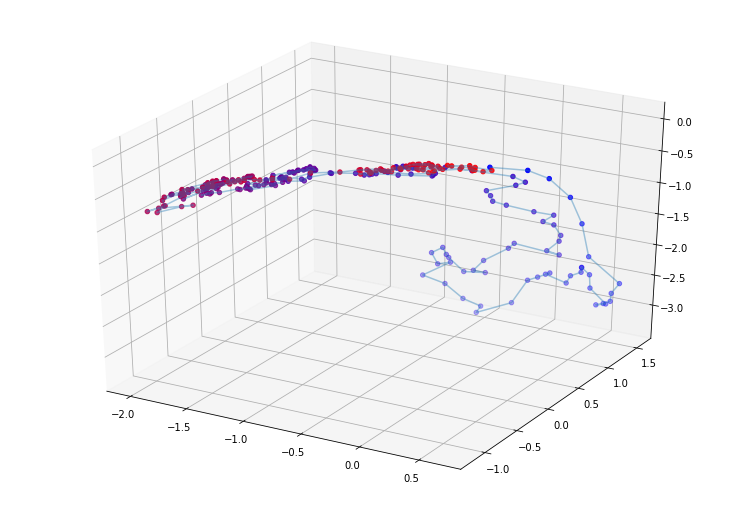

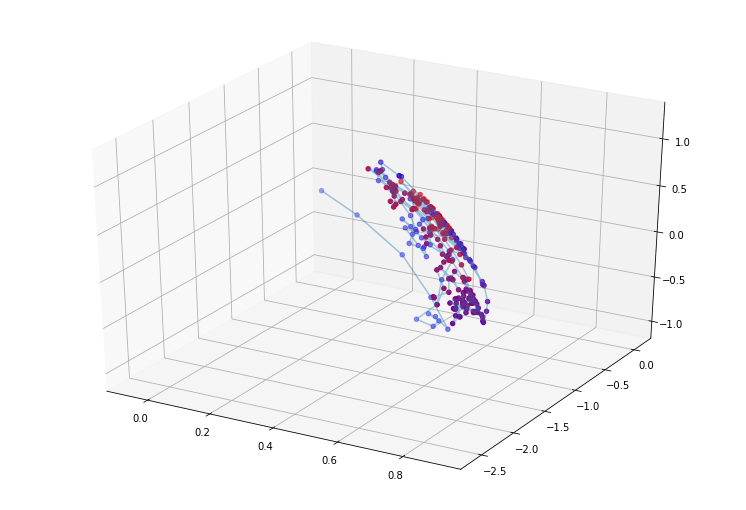

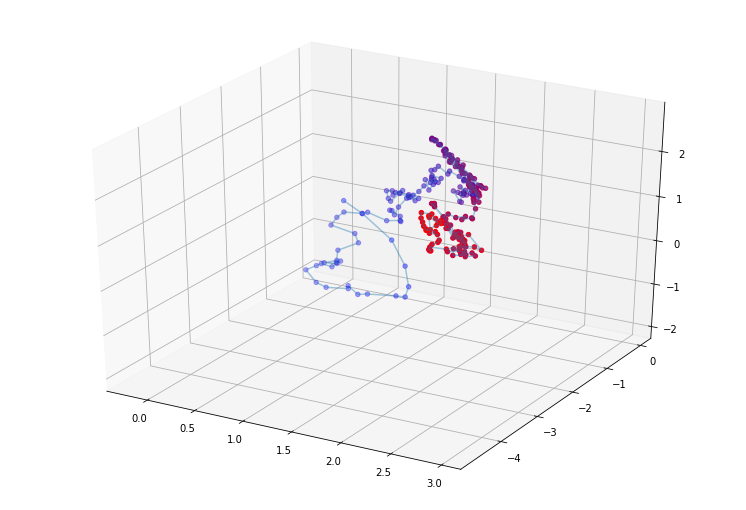

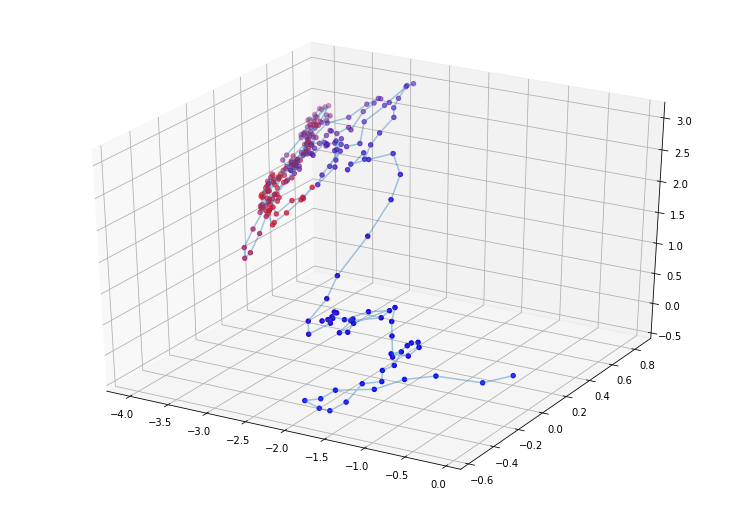

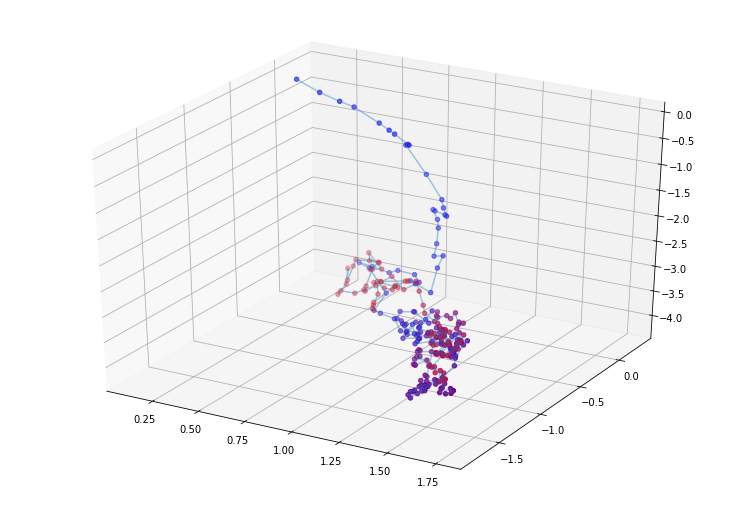

In [242]:
for i in range(10):
    plotRotationTrajectory(getRotationData(readXYZA(bxyzas[i])))
    plt.show()
        

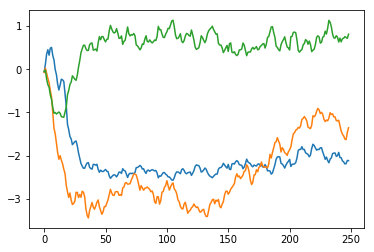

In [219]:
plt.plot([r[0] for r in rotation])
plt.plot([r[1] for r in rotation])
plt.plot([r[2] for r in rotation])
plt.show()

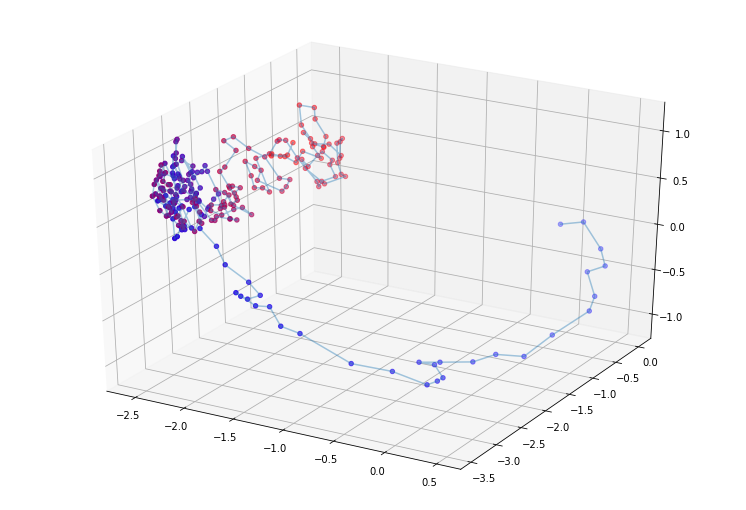